In [1]:
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
bsq = [
    "Does the article discuss agroecological practices?",
    "Does the article focus primarily on climate change mitigation?",
    "Does the article cover climate change adaptation?",
    "Does the article comprehensively cover climate change and environmental aspects?",
    "Does the study specifically evaluate greenhouse gas emissions?",
    "Does the article assess agroecological practices' impact on climate change?",
    "Does the article target stakeholders?",
    "Does the article address limitations, challenges, and potential risks?",
    "Does the article address policy implications?",
    "Does the article have a specific geographic focus?",
    "Does the article discuss the role of agroecology in enhancing climate resilience in agricultural systems?",
    "Does the article assess the impact of agroecology on nitrogen dynamics?",
    "Does the article discuss the impact of methane (CH4) emissions?"
]
len(bsq)

13

In [1]:
chatgpt_responses_b = []
for i in range(len(bsq)):
    if i+1 in [7, 5, 2]:
        chatgpt_responses_b.append(pd.read_excel(f"chatgpt_responses_b{i+1}_v2.xlsx", index_col=0))
    else:
        o = pd.read_excel(f"chatgpt_responses_b{i+1}.xlsx", index_col=0)
        o_ = pd.read_excel(f"chatgpt_responses_b{i+1}_v2.xlsx", index_col=0)
        chatgpt_responses_b.append(pd.concat([o, o_]))
    print(i+1, bsq[i])
    print(classification_report(chatgpt_responses_b[-1]["Final decision"] == "INCLUDE", chatgpt_responses_b[-1]["chatgpt"].apply(lambda x: int("Yes" in x)), digits=4))
    print(chatgpt_responses_b[-1]["chatgpt"].apply(lambda x: int("Yes" in x)).value_counts().to_dict())
    print(chatgpt_responses_b[-1].shape)

NameError: name 'bsq' is not defined

In [4]:
to_pred = chatgpt_responses_b[0].copy()
to_pred["b1"] = chatgpt_responses_b[0]["chatgpt"].apply(lambda x: int("Yes" in x))
for i in range(0, len(bsq)):
    to_pred[f"b{i+1}"] = chatgpt_responses_b[i]["chatgpt"].apply(lambda x: int("Yes" in x))

In [5]:
X = to_pred[[f"b{i+1}" for i in range(len(bsq))]]
y = (to_pred["Final decision"] == "INCLUDE").apply(int)

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

In [7]:
clf.fit(X, y)
clf.score(X, y)

0.8742138364779874

In [8]:
print(classification_report(y, clf.predict(X), digits=4))

              precision    recall  f1-score   support

           0     0.8696    0.9091    0.8889        88
           1     0.8806    0.8310    0.8551        71

    accuracy                         0.8742       159
   macro avg     0.8751    0.8700    0.8720       159
weighted avg     0.8745    0.8742    0.8738       159



In [10]:
row = to_pred[y != clf.predict(X)].sample(1).iloc[0]
print(f"""Title: {row["Article Title"]}\nAbstract: {row["Abstract (AB)"]}\nLabel: {row["Final decision"]}""")

Title: The potential of agroforestry to reduce atmospheric greenhouse gases in Canada: Insight from pairwise comparisons with traditional agriculture, data gaps and future research
Abstract: Canadian agriculture is a source of greenhouse gases (GHG) and agroforestry has the potential to sequester carbon (C), and mitigate agricultural GHG emissions. Agroforestry systems are common features in Canada's agricultural landscape; however, there are limited empirical data to support implementation of agroforestry practices for GHG mitigation. This shortfall of data may be a contributing factor to the lack of policy that supports the use of agroforestry for GHG mitigation in the Canadian agricultural landscape. We reviewed published studies that compared C stocks in vegetation and soils, and/or GHG emissions in agroforestry systems to traditional agriculture across Canada, with the aims of assessing the benefit of adopting agroforestry for GHG reduction. We then identified data gaps and obstac

In [11]:
columns = "Article Title  Abstract (AB)".split("  ")
recols = {"Article Title": "t", "Abstract (AB)": "ab"}
i = 0
o = chatgpt_responses_b[i][columns].rename(columns = recols)
o["q"] = bsq[i]
o["label"] = to_pred[f"b{i+1}"]
o = o.reset_index().drop(columns="index")
for i in range(1, len(bsq)):
        oi = chatgpt_responses_b[i][columns].rename(columns = recols)
        oi["q"] = bsq[i]
        oi["label"] = to_pred[f"b{i+1}"]
        oi = oi.reset_index().drop(columns="index")
        o = pd.concat([o, oi], ignore_index=True)
o

,t,ab,q,label
0,Does carbon farming provide a cost-effective o...,"In this study, we apply a whole farm bioeconom...",Does the article discuss agroecological practi...,1
1,Influence of Organic and Mineral Fertilizers o...,The intensive use of mineral (M) fertilizers m...,Does the article discuss agroecological practi...,1
2,Climate Change Mitigation Options in the Fores...,The Intergovernmental Panel on Climate Change ...,Does the article discuss agroecological practi...,1
3,Rye cover crop incorporation and high watertab...,Drainage and cultivation of peat soils almost ...,Does the article discuss agroecological practi...,1
4,Emerging Issues and Potential Opportunities in...,The rice-wheat cropping system (RWCS) is the b...,Does the article discuss agroecological practi...,1
...,...,...,...,...
2062,Crop-livestock integration provides opportunit...,CONTEXT: The Greater Mekong Subregion has been...,Does the article discuss the impact of methane...,1
2063,Pesticide Use and Associated Greenhouse Gas Em...,The production of synthetic pesticides is ener...,Does the article discuss the impact of methane...,0
2064,"A Review: Soil Management, Sustainable Strateg...",Conservative and sustainable soil management i...,Does the article discuss the impact of methane...,0
2065,Agricultural waste recycling in horticultural ...,The vegetables supply chain of intensive farmi...,Does the article discuss the impact of methane...,0


In [24]:
bsq_cols = list(set(o["q"]))
yes = []
no = []
for b in bsq_cols:
    d = o[o["q"] == b]["label"].value_counts().to_dict()
    if 0 in d:
        no.append(d[0])
    if 0 not in d:
        no.append(1)
    if 1 in d:
        yes.append(d[1])
    if 1 not in d:
        yes.append(0)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [163]:
yes_sort = list(np.argsort(yes))

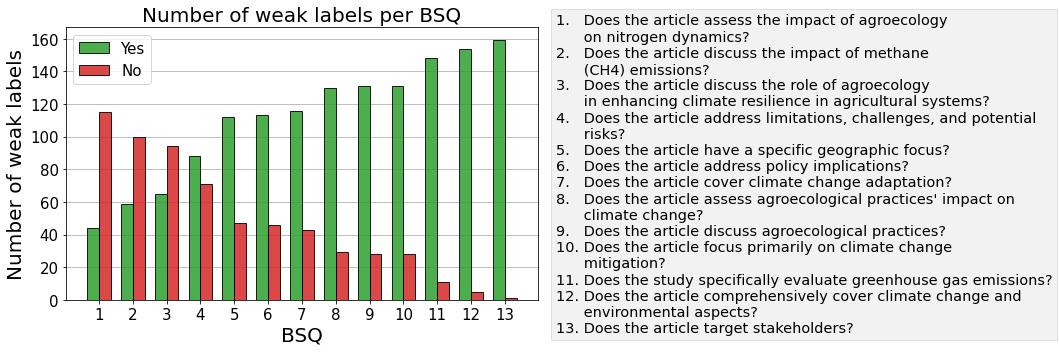

In [166]:
ind = np.arange(len(bsq_cols))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12*1.25, 5))
ax.grid(axis='y')
ax.set_axisbelow(True)
rects1 = ax.bar(ind - width/2, np.array(yes)[yes_sort], width, label='Yes', color="tab:green", edgecolor='black', alpha=0.85)
rects2 = ax.bar(ind + width/2, np.array(no)[yes_sort], width, label='No', color="tab:red", edgecolor='black', alpha=0.85)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of weak labels', fontsize=20)
ax.set_title('Number of weak labels per BSQ', fontsize=20)
ax.set_xticks(ind)

ax.set_xticklabels(range(1, 13+1), fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('BSQ', fontsize=20)
ax.legend(fontsize=15);
mx = 8
ax.text(13.5, -20, "\n".join([str(i+1)+". "+"  "*int(i+1<10)+str(" ".join(c.split()[:mx])) if len(c.split())<=mx else str(i+1)+". "+"  "*int(i+1<10)+str(" ".join(c.split()[:mx]))+"\n      "+str(" ".join(c.split()[mx:])) for i, c in enumerate(np.array(bsq_cols)[yes_sort])]),
        bbox={'facecolor': 'gray', 'alpha': 0.1, 'pad': 5}, fontsize=14.5)
fig.tight_layout()
fig.savefig("hist_bsqs.pdf")